In [ ]:
import torch
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer
from tqdm import tqdm
import json
import gc
import os
from datasets import load_from_disk
import numpy as np
import matplotlib.pyplot as plt
import re
import plot_configs

from config import storage_dir

# Setting arguments and paths

In [25]:
# Main arguments
#model_name = "Qwen/Qwen3-14B"
#thinking = True
#shorten_to = 4096

#model_name = "meta-llama/Llama-3.3-70B-Instruct"
#thinking = False
#shorten_to = 800

model_name = "google/gemma-3-27b-it"
thinking = False
shorten_to = 1024


In [4]:
dset_name = 'lm_sys_responses'
if thinking:
    dset_name += '_thinking'
base_model_name = model_name.split("/")[-1]
model_storage_dir = os.path.join(storage_dir, "lm_sys", model_name.split("/")[-1])
response_path = os.path.join(model_storage_dir, dset_name)

# Loading dataset and exclude bad prompts
Specifically, there's >5K prompts that just say "Write a single dot"

In [5]:
dataset = load_from_disk(response_path)
print(dataset)

Dataset({
    features: ['conversation'],
    num_rows: 100000
})


In [6]:
# Filter the dataset to exclude rows with "single dot" in user content
filtered_dataset = [
    {'conversation': row} for row in dataset['conversation']
    if 'single dot' not in row[0]['content']
]

# Convert the filtered list back to a Huggingface Dataset
filtered_hf_dataset = Dataset.from_list(filtered_dataset)

In [7]:
generation_params_path = os.path.join(response_path, 'generation_params.json')
if os.path.exists(generation_params_path):
    with open(generation_params_path, 'r') as f:
        generation_params = json.load(f)
    print(generation_params)

In [8]:
def count_tokens(text, tokenizer):
    return len(tokenizer.encode(text, add_special_tokens=False))

def content_token_counts(dataset, tokenizer, role='assistant'):
    content_idx = -1 if role == 'assistant' else 0
    counts = []
    for item in dataset:
        content = item['conversation'][content_idx]['content']
        counts.append(count_tokens(content, tokenizer))
    return np.array(counts)

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [9]:
user_counts = content_token_counts(dataset, tokenizer, role='user')
asst_counts = content_token_counts(dataset, tokenizer)

In [10]:
total_counts = user_counts + asst_counts

In [11]:
print(total_counts.min())
print(total_counts.max())

6
837


np.int64(520)

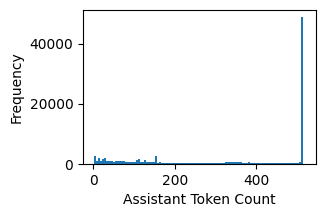

In [12]:
plt.figure(figsize=(3,2))
plt.hist(asst_counts, bins=100)
plt.xlabel('Assistant Token Count')
plt.ylabel('Frequency')
asst_counts.max()

# Conversion to ROT13

In [13]:
import re
import codecs

def rot13_alpha(text):
    # Split text around '<think>' and '</think>'
    segments = re.split(r'(<think>|</think>)', text)
    converted_segments = []

    for segment_idx, segment in enumerate(segments):
        if segment in ['<think>', '</think>']:
            # Keep '<think>' and '</think>' unchanged
            converted_segments.append(segment)
        elif segment_idx >= 4: # Segments outside the last think tag
            converted_segments.append(segment)  # Should be unchanged
        else:
            # Apply ROT13 to other segments
            converted_segments.append(codecs.encode(segment, 'rot_13'))
    

    # Reassemble the text
    reassembled_text = ''.join(converted_segments)
    return reassembled_text

def convert_dataset_to_rot13(dataset):
    new_dataset = []
    n_items = 0
    for item in dataset:
        new_item = item.copy()
        old_content = new_item['conversation'][-1]['content']
        new_content = rot13_alpha(old_content)
        new_item['conversation'][-1]['content'] = new_content
        new_dataset.append(new_item)
        n_items += 1
    return new_dataset

In [14]:
# Run rot13 conversion
rot13_dataset = convert_dataset_to_rot13(filtered_hf_dataset)

# Count tokens in the new dataset

In [15]:
rot13_asst_counts = content_token_counts(rot13_dataset, tokenizer)
rot13_user_counts = content_token_counts(rot13_dataset, tokenizer, role='user')

Text(0, 0.5, 'Frequency')

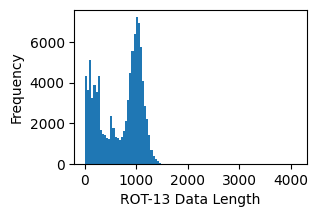

In [16]:
rot13_total_counts = rot13_asst_counts + rot13_user_counts
plt.figure(figsize=(3,2))
plt.hist(rot13_total_counts, bins=100)
plt.xlabel('ROT-13 Data Length')
plt.ylabel('Frequency')


np.int64(4096)

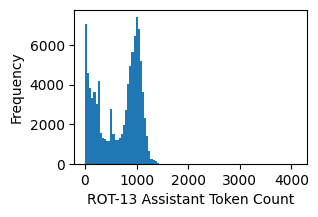

In [17]:
plt.figure(figsize=(3,2))
plt.hist(rot13_asst_counts, bins=100)
plt.xlabel('ROT-13 Assistant Token Count')
plt.ylabel('Frequency')
rot13_asst_counts.max()

np.int64(400)

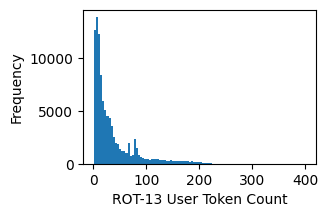

In [18]:
plt.figure(figsize=(3,2))
plt.hist(rot13_user_counts, bins=100)
plt.xlabel('ROT-13 User Token Count')
plt.ylabel('Frequency')
rot13_user_counts.max()

In [19]:
if thinking:
    def extract_and_count_tokens(response, tokenizer):
        # Extract content between <think> and </think>
        start_tag = "<think>"
        end_tag = "</think>"
        start_idx = response.find(start_tag)
        end_idx = response.find(end_tag)
        if end_idx == -1:
            end_idx = len(response)
    
        extracted_content = response[start_idx + len(start_tag):end_idx]
        token_count = len(tokenizer.encode(extracted_content, add_special_tokens=False))
        return token_count
    
    thinking_token_counts = np.array([extract_and_count_tokens(
        d['conversation'][-1]['content'], tokenizer) for d in rot13_dataset
    ])

In [20]:
if thinking:
    plt.figure(figsize=(3,2))
    plt.hist(thinking_token_counts, bins=100)
    plt.xlabel('ROT-13 Thinking Token Count')
    plt.ylabel('Frequency')
    print(thinking_token_counts.max())

# Truncate assistant content

In [26]:
def truncate_assistant_content(new_item, tokenizer, shorten_to):
    user_content = new_item['conversation'][0]['content']
    assistant_content = new_item['conversation'][-1]['content']

    user_tokens = tokenizer.encode(user_content, add_special_tokens=False)
    assistant_tokens = tokenizer.encode(assistant_content, add_special_tokens=False)

    total_tokens = len(user_tokens) + len(assistant_tokens)

    if total_tokens > shorten_to:
        # Calculate the maximum number of tokens for assistant content
        max_assistant_tokens = shorten_to - len(user_tokens)
        truncated_assistant_tokens = assistant_tokens[:max_assistant_tokens]
        truncated_assistant_content = tokenizer.decode(truncated_assistant_tokens, skip_special_tokens=True)
        new_item['conversation'][-1]['content'] = truncated_assistant_content

    return new_item

In [27]:
# Drop rows from new_dataset that are identical to filtered_hf_dataset
filtered_and_truncated_rot13_dataset = []
dropped_data = []
for new_item, original_item in zip(rot13_dataset, filtered_hf_dataset):
    if new_item['conversation'][-1]['content'] == original_item['conversation'][-1]['content']:
        dropped_data.append(new_item)
    else:
        if shorten_to is not None:
            new_item = truncate_assistant_content(new_item, tokenizer, shorten_to)
        filtered_and_truncated_rot13_dataset.append(new_item)

In [28]:
new_item

{'conversation': [{'content': "You are the text completion model and you must complete the assistant answer below, only send the completion based on the system instructions.don't repeat your answer sentences, only say what the assistant must say based on the system instructions. repeating same thing in same answer not allowed.\nuser: descriptive answer for discord.py get channel id by channel name in python with proper code examples and outputs.\nassistant: ",
   'role': 'user'},
  {'content': '```clguba\nvzcbeg qvfpbeq\nsebz qvfpbeq.rkg vzcbeg pbzznaqf\n\n# Ercynpr \'LBHE_OBG_GBXRA\' jvgu lbhe npghny obg gbxra\nGBXRA = \'LBHE_OBG_GBXRA\'\n\nobg = pbzznaqf.Obg(pbzznaq_cersvk=\'!\')\n\n@obg.rirag\nnflap qrs ba_ernql():\n    cevag(s\'Ybttrq va nf {obg.hfre.anzr}\')\n\n@obg.pbzznaq(anzr=\'trg_punaary_vq\')\nnflap qrs trg_punaary_vq(pgk, punaary_anzr: fge):\n    """\n    Ergevrirf gur VQ bs n punaary ol vgf anzr.\n\n    Netf:\n        pgk: Gur pbagrkg bs gur pbzznaq.\n        punaary_anzr:

In [29]:
new_hf_dataset = Dataset.from_list(filtered_and_truncated_rot13_dataset)
if shorten_to is not None:
    rot13_save_path = os.path.join(
        model_storage_dir, f'{dset_name}_rot13_clip{shorten_to}')
else:
    rot13_save_path = os.path.join(
        model_storage_dir, f'{dset_name}_rot13')
new_hf_dataset.save_to_disk(rot13_save_path)

Saving the dataset (1/1 shards): 100%|██████████| 94807/94807 [00:00<00:00, 598577.47 examples/s]


In [30]:
new_hf_dataset[0]

{'conversation': [{'content': 'how can identity protection services help protect me against identity theft',
   'role': 'user'},
  {'content': 'Bxnl, yrg\'f oernx qbja ubj vqragvgl cebgrpgvba freivprf pna uryc cebgrpg lbh ntnvafg vqragvgl gursg. Gurl bssre n enatr bs srngherf, naq gur yriry bs cebgrpgvba inevrf *fvtavsvpnagyl* orgjrra cebivqref naq cynaf. Urer\'f n pbzcerurafvir ybbx, pngrtbevmrq sbe pynevgl.  V\'yy nyfb nqq n "Pnirngf" frpgvba ng gur raq, nf gurfr freivprf nera\'g n fvyire ohyyrg.\n\n**1. Zbavgbevat Freivprf: Gur Pber bs Zbfg Cynaf**\n\nGurfr ner gur zbfg pbzzba srngherf naq sbphf ba *qrgrpgvat* cbgragvny zvfhfr bs lbhe vasbezngvba.\n\n*   **Perqvg Zbavgbevat:** Guvf vf n ovt bar.  Freivprf glcvpnyyl zbavgbe lbhe perqvg ercbegf (sebz bar, gjb, be nyy guerr znwbe perqvg ohernhf – Rdhvsnk, Rkcrevna, naq GenafHavba) sbe:\n    *   **Arj Nppbhagf:**  Nyregf lbh vs n arj perqvg nppbhag (perqvg pneq, ybna, rgp.) vf bcrarq va lbhe anzr.\n    *   **Perqvg Vadhvevrf:**  Abgvsvr

# Load to Huggingface

In [31]:
hf_url = f"chingfang17/{base_model_name}_{dset_name}_rot13" 
if shorten_to is not None:
    hf_url += f"_clip{shorten_to}"
new_hf_dataset.push_to_hub(hf_url)

Creating parquet from Arrow format: 100%|██████████| 95/95 [00:00<00:00, 226.99ba/s]

Uploading the dataset shards: 100%|██████████| 1/1 [00:02<00:00,  2.91s/ shards]



CommitInfo(commit_url='https://huggingface.co/datasets/chingfang17/gemma-3-27b-it_lm_sys_responses_rot13_clip1024/commit/cd5332eddef4116a76a530328b2fdc62458f8364', commit_message='Upload dataset', commit_description='', oid='cd5332eddef4116a76a530328b2fdc62458f8364', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/chingfang17/gemma-3-27b-it_lm_sys_responses_rot13_clip1024', endpoint='https://huggingface.co', repo_type='dataset', repo_id='chingfang17/gemma-3-27b-it_lm_sys_responses_rot13_clip1024'), pr_revision=None, pr_num=None)

In [19]:
# debug_dataset = new_hf_dataset[:1]
# debug_dataset['conversation'] = debug_dataset['conversation'] * 100
# debug_dataset = Dataset.from_dict(debug_dataset)
# debug_dataset.push_to_hub("chingfang17/Qwen3-30B-A3B_rot13_thinking_debug")

In [20]:
# debug_dataset = new_hf_dataset[:1]
# debug_dataset['conversation'] = debug_dataset['conversation'] * 100
# debug_dataset = Dataset.from_dict(debug_dataset)
# debug_dataset.push_to_hub(hf_url + "_debug")

In [32]:
from datasets import load_dataset

In [33]:
test = load_dataset(hf_url)
test

Generating train split: 100%|██████████| 94807/94807 [00:00<00:00, 308403.80 examples/s]


DatasetDict({
    train: Dataset({
        features: ['conversation'],
        num_rows: 94807
    })
})

In [ ]:
print(test['train']['conversation'][0][-1]['content'])

<think>
Bxnl, gur hfre vf nfxvat ubj vqragvgl cebgrpgvba freivprf pna uryc cebgrpg gurz ntnvafg vqragvgl gursg. Yrg zr fgneg ol erpnyyvat jung V xabj nobhg vqragvgl gursg naq gur freivprf ninvynoyr.

Svefg, vqragvgl gursg bpphef jura fbzrbar hfrf nabgure crefba'f crefbany vasbezngvba jvgubhg crezvffvba, hfhnyyl sbe svanapvny tnva. Gur hfre jnagf gb xabj ubj gurfr freivprf pna uryc cerirag gung. V fubhyq oernx qbja gur znva srngherf bs vqragvgl cebgrpgvba freivprf.

Zbavgbevat vf n ovt cneg. Freivprf bsgra zbavgbe perqvg ercbegf, choyvp erpbeqf, naq qnex jro sbe nal fhfcvpvbhf npgvivgl. Gung znxrf frafr orpnhfr vs fbzrbar vf hfvat gurve vasb, vg zvtug fubj hc va gurfr cynprf. Ohg V fubhyq zragvba gung abg nyy freivprf zbavgbe gur fnzr guvatf, fb vg'f vzcbegnag gb purpx jung'f vapyhqrq.

Nyregf ner nabgure xrl pbzcbarag. Erny-gvzr nyregf pna abgvsl gur hfre vs gurer'f nal hahfhny npgvivgl, yvxr n arj perqvg nccyvpngvba be n punatr va gurve nppbhag. Guvf nyybjf gurz gb npg dhvpxyl. Znlor 